# Assignment 3 Bonus

In [1]:
from __future__ import division, print_function
import glob
import os
import cv2
import PIL
import random
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from config_profile import args
from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64
from munkres import Munkres
from descriptor_CNN3 import DesNet
print("Done!")

Done!


In [2]:
print("Retreiving C_100...")
C_100 = torch.load("C_100_to_100_Tensor.pt")
print("C_100.shape:",C_100.shape)
print("Retreiving C...")
C = torch.load("C_10_to_10_Tensor.pt")
print("C.shape:",C.shape)
print("Done!")


Retreiving C_100...
C_100.shape: torch.Size([5, 100, 2, 3])
Retreiving C...
C.shape: torch.Size([5, 10, 2, 3])
Done!


In [67]:
print("Applying Thresholds for RANSAC...")
F_optimal = np.zeros((5,3,3))
rand_count = 40
C_optimal = np.zeros((5,rand_count,2,3))
new_opt = [True,True,True,True,True]
vals =  np.array([100, 100, 100, 100, 100])
epoch = 0
sanity = 1000
while True:
    epoch += 1
    F_rand = np.zeros((5,3,3))
    C_rand = np.zeros((5,rand_count,2,3))
    for i in range(0,5):
        C_rand_tmp = np.random.choice(100, rand_count-10, replace=False)
        c_index = 0
        for j in C[i]:
            for k in range(0,2):
                for l in range(0,3):
                    C_rand[i][c_index][k][l] = j[k][l]
            c_index += 1
        for j in C_rand_tmp:
            for k in range(0,2):
                for l in range(0,3):
                    C_rand[i][c_index][k][l] = C_100[i][j][k][l]
            c_index += 1
    W_rand = []
    for i in C_rand:
        W_t_rand = []
        for j in i:
            row_rand = []
            for k in j[1]:
                for l in j[0]:
                    row_rand.append(k*l)
            W_t_rand.append(row_rand)
        W_rand.append(W_t_rand)
    for i in range(0,len(W_rand)):
        u, s, vh = np.linalg.svd(W_rand[i])
        row_rand = vh[len(vh)-1]
        for j in range(0,len(row_rand)):
            F_rand[i][j%3][j//3] = row_rand[j]
    # Test optimizations
    val = np.zeros(5)
    for i in range (0,5):
        for j in range(0,rand_count):
            val[i] += np.abs(np.dot(np.dot(C_rand[i][j][1].T,F_rand[i]),C_rand[i][j][0]))
        if val[i] < vals[i]:
            print("Epoch:", epoch)
            print(i,":",vals[i], "->" , val[i])
            vals[i] = val[i]
            new_opt[i] = True
    # update
    for i in range(0,5):
        if new_opt[i]:
            print("Updating index " + str(i) + "...")
            for j in range(0,3):
                for k in range(0,3):
                    F_optimal[i][j][k] = F_rand[i][j][k]
            for j in range (0, rand_count):
                for k in range (0,2):
                    for l in range (0,3):
                        C_optimal[i][j][k][l] = C_rand[i][j][k][l]
    if not any(new_opt):
        sanity -= 1
    else:
        sanity = 1000
    if sanity == 0:
        break
    new_opt = [False,False,False,False,False]
print("Done with epoch at:", epoch)
print("Distances: ", vals)
print("Done!")

Applying Thresholds for RANSAC...
Epoch: 1
0 : 100 -> 8.354192169941498
Epoch: 1
1 : 100 -> 6.8931223587441135
Epoch: 1
2 : 100 -> 3.5441485943069972
Epoch: 1
3 : 100 -> 6.50065658044341
Epoch: 1
4 : 100 -> 3.347961717038255
Updating index 0...
Updating index 1...
Updating index 2...
Updating index 3...
Updating index 4...
Epoch: 3
2 : 3 -> 2.8320389900351106
Updating index 2...
Epoch: 4
3 : 6 -> 5.494904086162206
Updating index 3...
Epoch: 5
1 : 6 -> 5.891424091844565
Updating index 1...
Epoch: 6
3 : 5 -> 4.691112464025108
Epoch: 6
4 : 3 -> 2.7828006765104916
Updating index 3...
Updating index 4...
Epoch: 12
0 : 8 -> 7.786144420919473
Updating index 0...
Epoch: 24
1 : 5 -> 4.646772178195376
Updating index 1...
Epoch: 38
4 : 2 -> 1.3204871437754433
Updating index 4...
Epoch: 106
0 : 7 -> 6.89727824976233
Updating index 0...
Epoch: 113
1 : 4 -> 3.814907473076046
Updating index 1...
Epoch: 972
3 : 4 -> 3.8011016143424547
Updating index 3...
Done with epoch at: 1972
Distances:  [6 3 2 3 1

In [70]:
print("Optimal F:", F_optimal)
print("Optimal C:", C_optimal)
save = True
#save = False
if save:
    print("Saving F_optimal...")
    F_optimal = torch.Tensor(F_optimal)
    print("Shape of F_optimal: ",F_optimal.shape)
    torch.save(F_optimal, "F_optimal_Tensor.pt")
    print("Saving C_optimal...")
    C_optimal = torch.Tensor(C_optimal)
    print("Shape of C_optimal: ",C_optimal.shape)
    torch.save(C_optimal, "C_optimal_Tensor.pt")

Optimal F: [[[-5.56834277e-07  2.55687159e-06 -8.45250584e-04]
  [ 1.48339369e-06  9.88765642e-07 -1.67212790e-03]
  [-7.90267055e-04 -1.25582635e-03  9.99997144e-01]]

 [[-9.92077737e-07  2.89392674e-06  4.66703288e-05]
  [-4.45997688e-06 -8.53595947e-06  4.25066881e-03]
  [ 9.14024041e-04  2.14951089e-03 -9.99988237e-01]]

 [[ 5.76930812e-06  6.24170781e-06 -2.80648103e-03]
  [ 6.37460758e-06  7.87080921e-06 -3.27133156e-03]
  [-2.01730435e-03 -2.43643555e-03  9.99985708e-01]]

 [[ 9.37487441e-07  1.87044866e-06 -9.67772842e-04]
  [ 1.95614353e-06  1.39692292e-06 -1.34898576e-03]
  [-1.26936967e-03 -1.49633163e-03  9.99996697e-01]]

 [[ 1.16935614e-06 -2.32674162e-07 -9.27031048e-04]
  [ 1.60235326e-07  5.31365367e-08 -9.74930321e-05]
  [-1.27035338e-03  1.20310252e-04  9.99998751e-01]]]
Optimal C: [[[[1.070e+02 5.900e+01 1.000e+00]
   [1.490e+02 6.800e+01 1.000e+00]]

  [[1.650e+02 2.110e+02 1.000e+00]
   [1.980e+02 2.180e+02 1.000e+00]]

  [[1.800e+01 4.600e+02 1.000e+00]
   [6.100

# Testing

In [3]:
from __future__ import division, print_function
import glob
import os
import cv2
import PIL
import random
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from config_profile import args
from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64
from munkres import Munkres
from descriptor_CNN3 import DesNet
def get_epipolar_line(Fl, x1):
    l2 = np.dot(Fl,x1)
    return l2
def add_epipolar_line(im1, im2, l2, x1,x2):
    cv2.circle(im1,(x1[0],x1[1]), 5, (255,0,0), -1)
    cv2.circle(im2,(x2[0],x2[1]), 5, (255,0,0), -1)
    x_1 = 0
    y_1 = int((-l2[2])/(l2[1]))
    x_2 = int((-l2[2])/(l2[0]))
    y_2 = 0
    if x_2 <= im2.shape[1]:
        x_1 = 0
        y_1 = int(-(l2[0]*x_1 + l2[2])/(l2[1]))
        x_2 = im2.shape[1]
        y_2 = int(-(l2[0]*x_2 + l2[2])/(l2[1]))
    cv2.line(im2,(x_1,y_1),(x_2,y_2),(0,0,255),5)
    return [x_1,y_1] , [x_2,y_2]

def draw_image(im1, im2, display):
    if display:
        plt.imshow(im1)
        plt.show()
        plt.imshow(im2)
        plt.show()
print("loading C and F...")
print ("Loading F_10")
F = torch.load("F_10_to_10_Tensor.pt")
print ("Loading F_optimal")
F_optimal = torch.load("F_optimal_Tensor.pt")
print ("Loading C_10")
C = torch.load("C_10_to_10_Tensor.pt")
print ("Loading C_optimal")
C_optimal = torch.load("C_optimal_Tensor.pt")
print("F:", F.shape)
print("C:", C.shape)
print("F_optimal:", F_optimal.shape)
print("C_optimal:", C_optimal.shape)
print("Done!")

loading C and F...
Loading F_10
Loading F_optimal
Loading C_10
Loading C_optimal
F: torch.Size([5, 3, 3])
C: torch.Size([5, 10, 2, 3])
F_optimal: torch.Size([5, 3, 3])
C_optimal: torch.Size([5, 40, 2, 3])
Done!


10 points:
RANSAC points:
x_1: [tensor([973., 687.,   1.])], x_2: [tensor([995., 697.,   1.])]
l_1: [[ 3.8283877e-04  4.9301854e-04 -6.6162956e-01]]
x_1: [tensor([352., 313.,   1.])], x_2: [tensor([377., 313.,   1.])]
l_2: [[-2.4095539e-04 -8.4048964e-04  3.2874948e-01]]


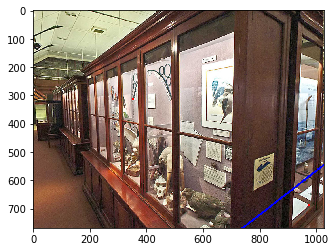

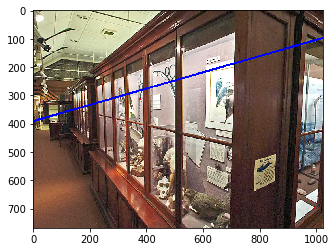

x_1: [tensor([420., 193.,   1.])], x_2: [tensor([452., 191.,   1.])]
l_1: [[ 1.5099120e-04  6.0439110e-04 -1.7629284e-01]]
x_1: [tensor([440., 493.,   1.])], x_2: [tensor([445., 493.,   1.])]
l_2: [[ 0.00103686 -0.00191995  0.4618911 ]]


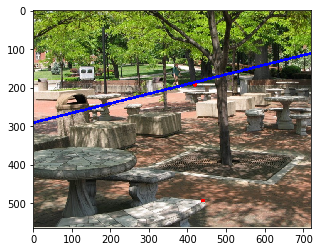

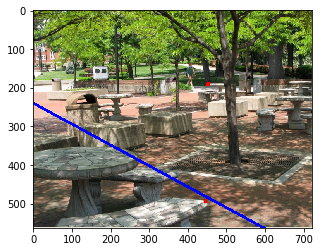

x_1: [tensor([301.,  20.,   1.])], x_2: [tensor([265.,  22.,   1.])]
l_1: [[-0.0011403  -0.0014089   0.41179848]]
x_1: [tensor([385., 115.,   1.])], x_2: [tensor([352., 113.,   1.])]
l_2: [[ 1.3249903e-04  8.8035362e-05 -5.6866527e-02]]


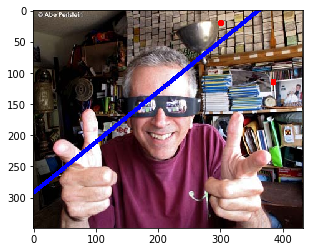

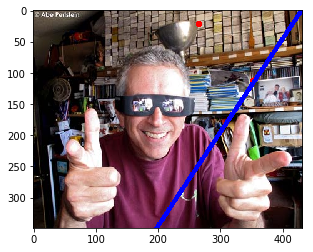

x_1: [tensor([480., 146.,   1.])], x_2: [tensor([522., 150.,   1.])]
l_1: [[-0.00019784 -0.00011834  0.11293602]]
x_1: [tensor([355., 619.,   1.])], x_2: [tensor([469., 659.,   1.])]
l_2: [[ 5.2284281e-04  2.1014048e-04 -3.7685877e-01]]


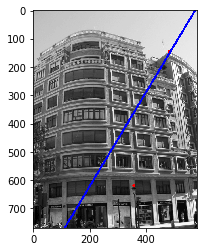

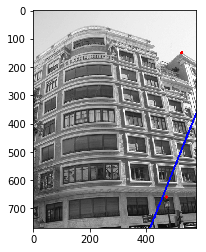

x_1: [tensor([723., 389.,   1.])], x_2: [tensor([778., 394.,   1.])]
l_1: [[-1.0894565e-04  4.8105852e-05  5.9066117e-02]]
x_1: [tensor([1.0710e+03, 3.9200e+02, 1.0000e+00])], x_2: [tensor([1.1460e+03, 3.9700e+02, 1.0000e+00])]
l_2: [[ 2.3414113e-04  9.4948540e-05 -3.1338805e-01]]


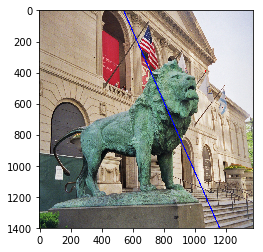

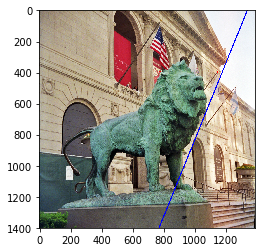

In [177]:
p1 = [7,9,8,7,5] #[7,9,8,7,5]
p2 = [4,6,2,3,2] #[4,6,2,3,2]
print("10 points:")
save = True
#save = False
display = True
#display = False
print("RANSAC points:")
for i in range(1,6):
    Path1 = "./images/image"+str(i)+str(1)+".png"
    Path2 = "./images/image"+str(i)+str(2)+".png"
    im1 = cv2.cvtColor(cv2.imread(Path1), cv2.COLOR_BGR2RGB)
    im2 = cv2.cvtColor(cv2.imread(Path2), cv2.COLOR_BGR2RGB)
    l1 = get_epipolar_line(F_optimal[i-1], C_optimal[i-1][p2[i-1]][1])
    add_epipolar_line(im2, im1, l1, C_optimal[i-1][p2[i-1]][1],C_optimal[i-1][p2[i-1]][0])
    print("x_1: [" + str(C_optimal[i-1][p2[i-1]][0]) + "], x_2: ["+ str(C_optimal[i-1][p2[i-1]][1]) + "]")
    print("l_1: [" + str(l1) + "]")
    l2 = get_epipolar_line(F_optimal[i-1], C_optimal[i-1][p1[i-1]][0])
    add_epipolar_line(im1, im2, l2, C_optimal[i-1][p1[i-1]][0],C_optimal[i-1][p1[i-1]][1])
    print("x_1: [" + str(C_optimal[i-1][p1[i-1]][0]) + "], x_2: ["+ str(C_optimal[i-1][p1[i-1]][1]) + "]")
    print("l_2: ["+ str(l2) + "]")
    draw_image(im1,im2,display)
    im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2BGR)
    im2 = cv2.cvtColor(im2, cv2.COLOR_RGB2BGR)
    if save:
        cv2.imwrite("./image resaults/bonus-resault-RANSAC-" + str(i) + "-1.png", im1)
        cv2.imwrite("./image resaults/bonus-resault-RANSAC-" + str(i) + "-2.png", im2)

# Epipoles

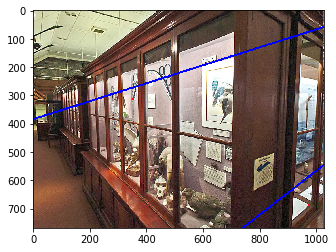

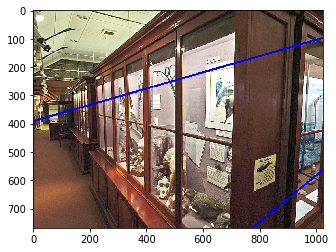

e_1_optimal: [2084.01392476137, -276.28163952835484]
e_2_optimal: [1894.301734012052, -152.01464662662195]


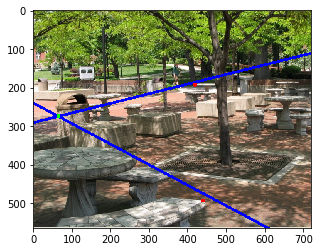

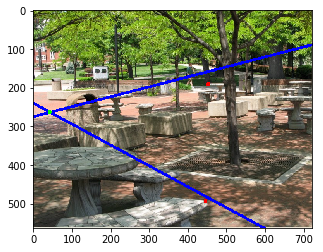

e_1_optimal: [65.33737278690322, 274.70764740275166]
e_2_optimal: [43.83030963179886, 263.70352844541264]


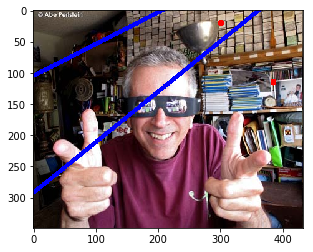

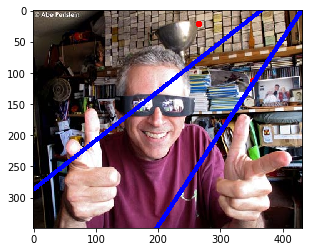

e_1_optimal: [622.8538461538461, -211.46153846153845]
e_2_optimal: [500.50485436893206, -106.91585760517799]


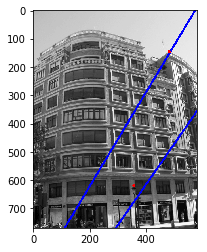

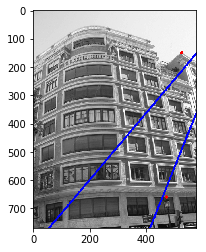

e_1_optimal: [-1019.3849864335243, 2655.914380464275]
e_2_optimal: [735.5023897318131, -38.60525665158453]


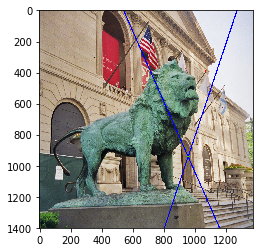

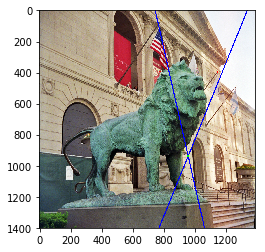

e_1_optimal: [957.779623477298, 941.4130675526025]
e_2_optimal: [958.3047579123873, 937.3783273946761]


In [5]:
display = True
save = True
def line_intersection(im,line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    cv2.circle(im,(int(x),int(y)), 5, (0,255,0), -1)
    return [x, y]
p1 = [7,9,8,7,5] #[7,9,8,7,5]
p2 = [4,6,2,3,2] #[4,6,2,3,2]
P=[
    p1,
    p2
]
for i in range(1,6):
    Path1 = "./images/image"+str(i)+str(1)+".png"
    Path2 = "./images/image"+str(i)+str(2)+".png"
    im1 = cv2.cvtColor(cv2.imread(Path1), cv2.COLOR_BGR2RGB)
    im2 = cv2.cvtColor(cv2.imread(Path2), cv2.COLOR_BGR2RGB) 
    l_1_optimal_1 = get_epipolar_line(F_optimal[i-1], C_optimal[i-1][P[0][i-1]][1])
    A = add_epipolar_line(im2, im1, l_1_optimal_1, C_optimal[i-1][P[0][i-1]][1],C_optimal[i-1][P[0][i-1]][0])
    l_1_optimal_2 = get_epipolar_line(F_optimal[i-1], C_optimal[i-1][P[1][i-1]][1])
    B = add_epipolar_line(im2, im1, l_1_optimal_2, C_optimal[i-1][P[1][i-1]][1],C_optimal[i-1][P[1][i-1]][0])
    e_1_optimal = line_intersection(im1, A,B)
    l_2_optimal_1 = get_epipolar_line(F_optimal[i-1], C_optimal[i-1][P[0][i-1]][0])
    A = add_epipolar_line(im1, im2, l_2_optimal_1, C_optimal[i-1][P[0][i-1]][0],C_optimal[i-1][P[0][i-1]][1])
    l_2_optimal_2 = get_epipolar_line(F_optimal[i-1], C_optimal[i-1][P[1][i-1]][0])
    B = add_epipolar_line(im1, im2, l_2_optimal_2, C_optimal[i-1][P[1][i-1]][0],C_optimal[i-1][P[1][i-1]][1])
    e_2_optimal =line_intersection(im2, A,B)
    draw_image(im1,im2,display)
    if save:
        im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2BGR)
        im2 = cv2.cvtColor(im2, cv2.COLOR_RGB2BGR)
        cv2.imwrite("./image resaults/resault-RANSAC-" + str(i) + "-1-e.png", im1)
        cv2.imwrite("./image resaults/resault-RANSAC-" + str(i) + "-2-e.png", im2)
    
    print("e_1_optimal:",e_1_optimal)
    print("e_2_optimal:",e_2_optimal)